In [28]:
# SECTION 1: Data Loading and Preprocessing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

np.random.seed(42)

# --- Load Data ---
train_df = pd.read_csv('Customer_train.csv')
test_df = pd.read_csv('Customer_test.csv')

# --- Drop ID columns for modeling, keep for output ---
train_df = train_df.drop(columns=['ID'])
test_ids = test_df['ID']
test_df = test_df.drop(columns=['ID'])

# --- Handle missing values in CATEGORICAL columns ---
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
for df in [train_df, test_df]:
    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown').replace('', 'Unknown')

# --- Handle missing values in NUMERICAL columns ---
num_cols = ['Age', 'Work_Experience', 'Family_Size']
imputer = SimpleImputer(strategy='median')
train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = imputer.transform(test_df[num_cols])

# --- Consistent Label Encoding for all categorical columns ---
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on BOTH train and test (makes sure all possible values exist)
    to_fit = pd.concat([train_df[col], test_df[col]], axis=0)
    le.fit(to_fit.astype(str))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

# --- Prepare target ---
y = train_df['Segmentation']
X = train_df.drop(columns=['Segmentation'])

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# --- Stratified validation split, fully reproducible ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Numeric Scaling ---
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

print("Cleaned, encoded, and split data.")


Cleaned, encoded, and split data.


In [29]:
# 2. Random Forest Utility Functions

from sklearn.tree import DecisionTreeClassifier
from collections import Counter

def bootstrap_sample(X, y, random_state=None):
    n_samples = X.shape[0]
    rng = np.random.default_rng(seed=random_state)
    indices = rng.choice(n_samples, n_samples, replace=True)
    return X.iloc[indices], y[indices]

def train_random_forest(X, y, n_trees=100, max_depth=None, base_seed=42):
    trees = []
    for i in range(n_trees):
        # Unique per-tree random state for strict reproducibility
        X_s, y_s = bootstrap_sample(X, y, random_state=base_seed + i)
        tree = DecisionTreeClassifier(max_depth=max_depth, random_state=base_seed + i)
        tree.fit(X_s, y_s)
        trees.append(tree)
    return trees

def predict_random_forest(trees, X):
    preds = np.array([tree.predict(X) for tree in trees])
    preds_majority = []
    for i in range(X.shape[0]):
        counts = Counter(preds[:, i])
        preds_majority.append(counts.most_common(1)[0][0])
    return np.array(preds_majority)

print("Random forest helper functions ready.")


Random forest helper functions ready.


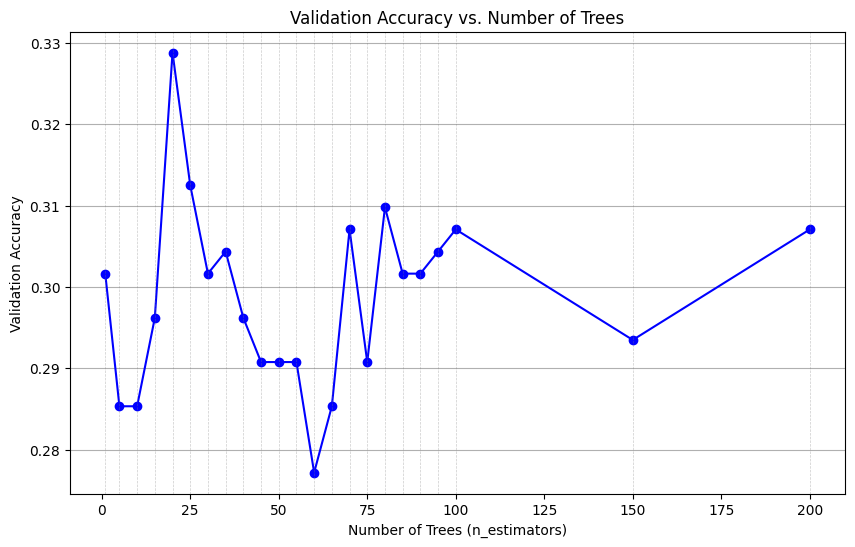

Best accuracy at n = 20


In [43]:
import matplotlib.pyplot as plt

# Choose tree steps for measurement (matches friend's style)
n_list = [1] + list(range(5, 101, 5)) + [150, 200] # 1, 5, 10, ..., 200

# Train ONE large random forest
max_n = max(n_list)
trees = train_random_forest(X_train, y_train, n_trees=max_n)

accuracies = []
for n in n_list:
    y_val_pred = predict_random_forest(trees[:n], X_val)
    acc = (y_val_pred == y_val).mean()
    accuracies.append(acc)

# Plot to match friend's style
plt.figure(figsize=(10, 6))
plt.plot(n_list, accuracies, marker='o', color='blue')
plt.title('Validation Accuracy vs. Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation Accuracy')

# Add major gridlines at your plotted steps
for n in n_list:
    plt.axvline(x=n, color='grey', linestyle='--', linewidth=0.5, alpha=0.4)
plt.grid(axis='y')

plt.show()

# Print out best accuracy and the corresponding n
best_n = n_list[np.argmax(accuracies)]
print("Best accuracy at n =", best_n)


In [45]:
# 4. Final Model Selection, Test Prediction, Evaluation Printout

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

best_n =tree_counts[np.argmax(cumulative_accuracies)]
print(f'\nTraining final Random Forest with {best_n} trees...')

trees_final = trees[:best_n]

# Validation metrics
y_val_pred_final = predict_random_forest(trees_final, X_val)
print("\nVALIDATION SET PERFORMANCE:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_final))
print("\nClassification report:\n", classification_report(y_val, y_val_pred_final, target_names=target_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_final))

# Test prediction
y_test_pred = predict_random_forest(trees_final, test_df)
y_test_labels = target_encoder.inverse_transform(y_test_pred)

# Create a DataFrame for nice display
output_df = pd.DataFrame({'ID': test_ids, 'Predicted_Segmentation': y_test_labels})

# Print the full predictions
print("Test Set Predictions:")
print(output_df.to_string(index=False))

#  save to CSV too
# output_df.to_csv('teamid_rf_predictions.csv', index=False)




Training final Random Forest with 21 trees...

VALIDATION SET PERFORMANCE:
Accuracy: 0.328804347826087

Classification report:
               precision    recall  f1-score   support

           A       0.40      0.43      0.41       116
           B       0.26      0.23      0.24        78
           C       0.22      0.23      0.23        64
           D       0.36      0.35      0.35       110

    accuracy                           0.33       368
   macro avg       0.31      0.31      0.31       368
weighted avg       0.33      0.33      0.33       368


Confusion Matrix:
 [[50 14 16 36]
 [22 18 19 19]
 [21 16 15 12]
 [33 22 17 38]]

Sample Test Predictions: ['A' 'C' 'D' 'D' 'A' 'A' 'A' 'A' 'D' 'B']
Test Set Predictions:
    ID Predicted_Segmentation
459678                      A
460051                      C
462094                      D
467493                      D
463766                      A
460470                      A
461226                      A
459090                   